In [2]:
# Imports 
import os
import numpy as np
import librosa
from matplotlib import pyplot as plt

# Reading Data

Create data structure for each peice of audio.
- Audio file
- Annotation file
- annotated beats
- tracked beats
- evaluation?

### Single file loading

In [285]:
# get file
file_path = 'data/BallroomData/ChaChaCha/Albums-Cafe_Paradiso-08.wav'

# resample rate - based on method of ellis 2007
resample_rate = 8000

# load audio
y, sr = librosa.load(file_path, sr=resample_rate)



# Onset Strength Envelope

Calculating a perceptually weighted onset strength envelope.
- Audio resampled to 8 kHz
- Calculate STFT 32ms window, 4ms hop size 
- Mapped to 40 band Mel spectrogram
- Mel converted to dB
- First order difference along time calculated for each band
- Half wave rectification (Negative value set to zero)
- Sum across bands
- High pass filter 0.4 Hz (make it locally zero mean)
- Convolved with Gaussian envelope 20ms wide 
- Normalise onset envelope by dividing by musical excerpt standard deviation

This should result in 1D onset envelope strength as a function of time that responds to a proportional increase in energy summed across approximately auditory frequency bands.

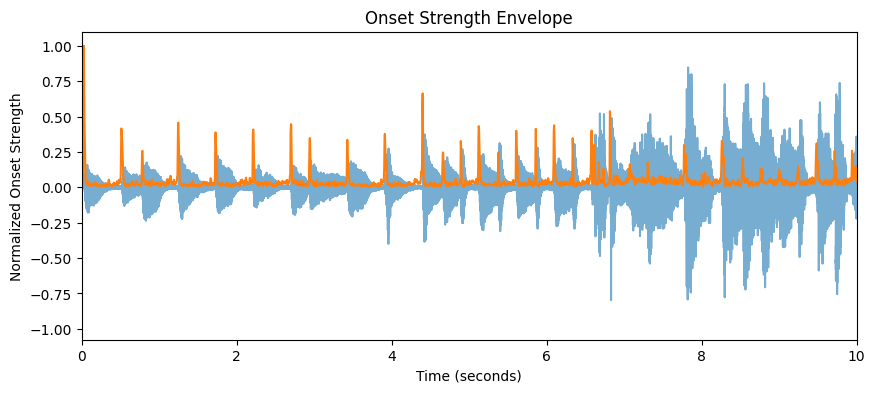

In [302]:
from scipy.signal import butter, filtfilt, gaussian, convolve

# butterworth highpass filter
def high_pass_filter(y, sr, cutoff=0.4, order=1):
    """Apply a high-pass filter to the signal."""
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y, axis=0)
    return y_filtered

# def apply_gaussian_envelope(strength_envelope, sr, width_ms=2):
#     # Convert width in ms to standard deviation in samples
#     sigma = (sr * width_ms / 1000) / np.sqrt(8 * np.log(2))
    
#     # Calculate kernel size, ensure it's odd for symmetry
#     kernel_size = int(6 * sigma) | 1
    
#     # Generate Gaussian kernel
#     t = np.arange(kernel_size) - kernel_size // 2
#     gaussian_kernel = np.exp(-0.5 * (t / sigma) ** 2)
#     gaussian_kernel /= np.sum(gaussian_kernel)  # Normalize the kernel
    
#     # Apply Gaussian smoothing
#     smoothed_strength_envelope = convolve(strength_envelope, gaussian_kernel, mode='same')
    
#     return smoothed_strength_envelope


def mel_db(sr, stft, n_fft, hop_length, n_mels=40):
    abs_stft = abs(stft)
    
    # Create a Mel spectrogram with 40 Mel bands
    mel = librosa.feature.melspectrogram(S=abs_stft**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert power spectrogram (amplitude squared) to dB
    mel_db = librosa.power_to_db(mel)
    
    return mel_db
    
# Onset strength envelope
def onset_strength_envelope(y, sr, window_sec=0.032, hop_sec=0.004):    
    # Calculate the STFT with a 32ms window and 4ms hop size
    n_fft = int(window_sec * sr)  # Window seconds to samples
    hop_length = int(hop_sec * sr)  # Hop seconds to samples
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # apply mel scale with 40 bands
    mel = mel_db(sr, stft, n_fft, hop_length)
    
    # apply first order difference
    mel_dif = np.diff(mel, axis=1)
    
    # half wave rectify
    mel_half_rec = np.maximum(0, mel_dif)
    
    # sum across bands
    onset_strength = np.sum(mel_half_rec , axis=0)
    
    # librosa do it like this - onset_env = scipy.signal.lfilter([1.0, -1.0], [1.0, -0.99], onset_env, axis=-1)
    # onset_strength_filtered = high_pass_filter(onset_strength, sr)
    
    #  normalise to standard deviation (add small number to avoid div by 0) 
    # find significant difference from mean   
    onset_strength_std_norm  = onset_strength / np.std(onset_strength) + 1e-10 
    
    onset_strength_min_max_norm = onset_strength / np.max(onset_strength)
    
    return onset_strength_std_norm, onset_strength_min_max_norm

def plot_onset_envelope_strength(y, onset_strength, hop_sec):
    hop_length = int(hop_sec * sr)
    # Time vector for plotting
    times = librosa.frames_to_time(np.arange(len(onset_strength)), sr=sr, hop_length=hop_length)
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
    plt.plot(times, onset_strength)
    plt.title('Onset Strength Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Onset Strength')
    plt.xlim([0, 10])
    plt.show()
      
    # # Plot the Mel spectrogram
    # plt.figure(figsize=(10, 4))
    # librosa.display.specshow(mel, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel Spectrogram')
    # plt.tight_layout()
    # plt.show()

hop_sec = 0.004

# seperate functions for normalising
odf_std_norm, odf_min_max_norm = onset_strength_envelope(y, sr)

plot_onset_envelope_strength(y, odf_min_max_norm, hop_sec)





# Global Tempo Estimate

Dynamic programming method dependant on tempo estimate.
- Use autocorrelation on onset strength envelope
- Apply perceptual weighting Gaussian window to raw autocorrelation
    - Gives TPS
    - Using T0 = 0.5 secs omegaT = 1.4 octaves
- Pick largest peak from TPS for tempo estimate

Extension:
Resample TPS to a half and a third, then adding the result to the original signal and picking the largest peak for tempo estimate.
- uses different values for T0 and omegaT

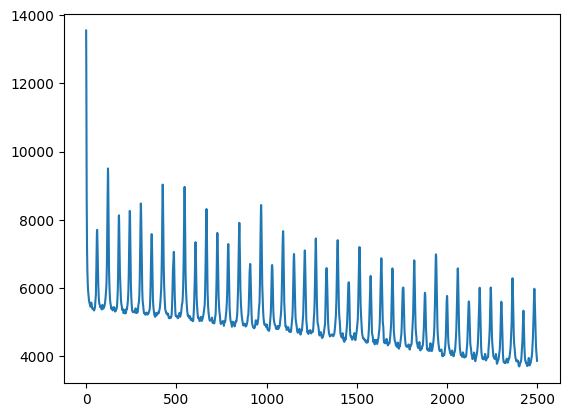

In [296]:
# Tempo Estimate using auto correlation
odf = onset_strength_envelope(y, sr)

hop_length = int(hop_sec * sr)
max_size = 10 * sr // hop_length

# write my own
auto_c = librosa.autocorrelate(odf)

hop_length = int(hop_sec * sr)

plt.plot(auto_c)



# Beat Tracking
- Using dynamic programming to find each beat.
- Follow source code on Ellis 2007 paper.

# Beat Tracking

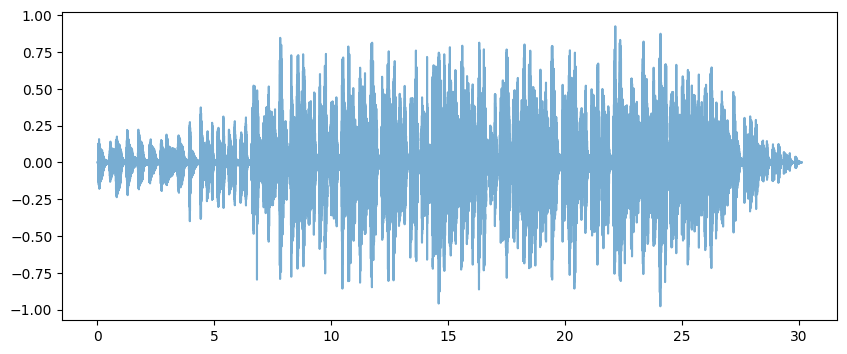

In [300]:


tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr) # to get times from indexes

plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
plt.vlines(beats, ymin=min(y), ymax=max(y), color='r', linestyle='--', label='Onsets')  # Plot beats
plt.title('Beat tracking - BPM: {}'.format(tempo))

